In [32]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split 
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier


In [2]:
def wrangle(file):
    try:
        #read csv
        df = pd.read_csv(file)

        #remove whitespace in columns
        df.columns = df.columns.str.strip()

        # columns to drop
        cols_to_drop =['Adm5', 'Adm6', 'Geo1', 'econ4', 'acc_code', 'FndSrce1', 'function2', 'econ1', 'econ2', 'econ3', 'Year', 'Adm2', 'Adm3', 'Adm4']
        
        #convert numerical columns to float
        num_cols = ['Estimates', 'Revised', 'Executed']
        for col in num_cols:
            df[col] = df[col].str.replace(',', '', regex=True).str.replace(r'[^\d\.\-]', '', regex=True).replace(['', '-'], np.nan).astype(float)

        #split funding source
        df[['acc_code', 'fund_source']] = df['FndSrce1'].str.lower().str.split(n=1, expand=True)

        #clean function 1
        df['function1'] = df['function1'].str.lower().str.strip()    
        
        #get ratio
        df['execution_ratio'] = np.where(df['Revised'] == 0, 0, df['Executed'] / df['Revised'])
        #remove outliers
        df = df[df['execution_ratio'] <= 2.0]
        
        #execution status
        df['fully_executed'] = (df['execution_ratio']>= 1).astype(int)
        
        #drop leaky features
        cols_to_drop.extend(['Executed', 'execution_ratio'])
        
        #drop columns
        df.drop(columns = cols_to_drop, inplace=True)
        
        #drop missing rows
        df.dropna(inplace=True)

        #reorder columns
        revised_order = ['Class', 'Adm1', 'Econ0', 'function1','fund_source', 'Estimates', 'Revised', 'fully_executed']
        df = df[revised_order]       
        
        return df
        
    except Exception as e:
        print(f'Encountered {e} error')

    


In [3]:
df = wrangle('kenya-boost-2006-2018.csv')
df.head()

/tmp/ipykernel_2843/4088470531.py:4: DtypeWarning: Columns (0,1,2,3,4,5,6,7,9,10,11,12,15,16,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


,Class,Adm1,Econ0,function1,fund_source,Estimates,Revised,fully_executed
0,Development,Central,Expenditures,agriculture and rural development,domestic resources,18318600.0,14062700.0,0
1,Development,Central,Expenditures,agriculture and rural development,domestic resources,12799450.0,9599587.0,0
2,Development,Central,Expenditures,agriculture and rural development,domestic resources,7218400.0,5652150.0,0
3,Development,Central,Expenditures,agriculture and rural development,domestic resources,10025827.0,8126744.0,0
4,Development,Central,Expenditures,agriculture and rural development,domestic resources,500000.0,1130625.0,0


In [4]:
df['fully_executed'].value_counts()

fully_executed
0    53123
1    22763
Name: count, dtype: int64

In [5]:
columns = df.columns
print(columns)
for col in columns:
    print(f'Value counts for {col} column')
    try:
        print(df[col].unique())
    except Exception as e:
        print(f"Error in column '{col}': {e}")
    print('------------------')
    print('******************')

Index(['Class', 'Adm1', 'Econ0', 'function1', 'fund_source', 'Estimates',
       'Revised', 'fully_executed'],
      dtype='object')
Value counts for Class column
['Development' 'Recurrent']
------------------
******************
Value counts for Adm1 column
['Central' 'Social security' 'Local Authorities' ' Central ']
------------------
******************
Value counts for Econ0 column
['Expenditures' 'Below the line' 'A-in-A']
------------------
******************
Value counts for function1 column
['agriculture and rural development' 'human resource development'
 'debt/pensions' 'governance, justice, law and order'
 'public administration and international relations'
 'environment, water and irrigation' 'trade, tourism and industry'
 'special programmes' 'physical infrastructure'
 'research,innovation and technology' 'national security' 'other']
------------------
******************
Value counts for fund_source column
['domestic resources' 'appropriation in aid (aia)' 'revenue']
------

In [6]:
df.columns.str.strip()

Index(['Class', 'Adm1', 'Econ0', 'function1', 'fund_source', 'Estimates',
       'Revised', 'fully_executed'],
      dtype='object')

In [7]:
if 'Estimates' in df.columns:
    print(df['Estimates'].head())
else:
    print('Estimates column not there')

0    18318600.0
1    12799450.0
2     7218400.0
3    10025827.0
4      500000.0
Name: Estimates, dtype: float64


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75886 entries, 0 to 262022
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Class           75886 non-null  object 
 1   Adm1            75886 non-null  object 
 2   Econ0           75886 non-null  object 
 3   function1       75886 non-null  object 
 4   fund_source     75886 non-null  object 
 5   Estimates       75886 non-null  float64
 6   Revised         75886 non-null  float64
 7   fully_executed  75886 non-null  int64  
dtypes: float64(2), int64(1), object(5)
memory usage: 5.2+ MB


In [9]:
df['function1'] = df['function1'].str.lower().str.strip()


In [10]:
df.columns

Index(['Class', 'Adm1', 'Econ0', 'function1', 'fund_source', 'Estimates',
       'Revised', 'fully_executed'],
      dtype='object')

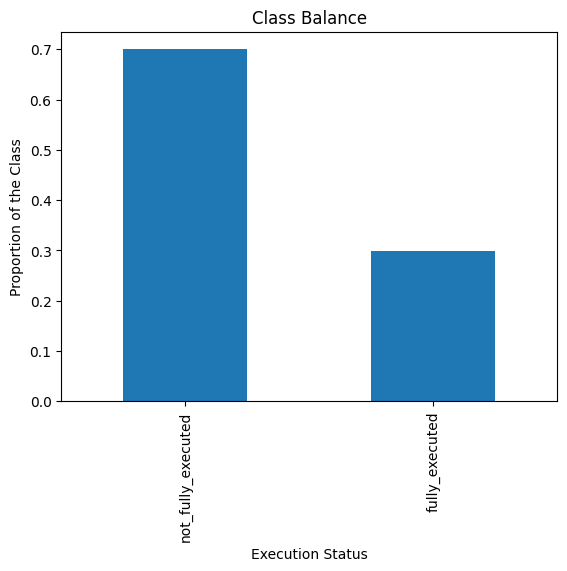

In [11]:
df['fully_executed'].value_counts(normalize=True).plot(kind ='bar')
plt.xlabel('Execution Status')
plt.ylabel('Proportion of the Class')
plt.title('Class Balance')
plt.xticks([0, 1], ['not_fully_executed', 'fully_executed']);

In [12]:
majority_class, minority_class = df['fully_executed'].value_counts(normalize=True)
print('Majority class:', round(majority_class, 3),':', 'Minority class:', round(minority_class, 3))

Majority class: 0.7 : Minority class: 0.3


In [13]:
df.head()

,Class,Adm1,Econ0,function1,fund_source,Estimates,Revised,fully_executed
0,Development,Central,Expenditures,agriculture and rural development,domestic resources,18318600.0,14062700.0,0
1,Development,Central,Expenditures,agriculture and rural development,domestic resources,12799450.0,9599587.0,0
2,Development,Central,Expenditures,agriculture and rural development,domestic resources,7218400.0,5652150.0,0
3,Development,Central,Expenditures,agriculture and rural development,domestic resources,10025827.0,8126744.0,0
4,Development,Central,Expenditures,agriculture and rural development,domestic resources,500000.0,1130625.0,0


In [14]:
#split data into features and target
X = df.drop('fully_executed', axis=1)
print('X.shape:', X.shape)
y = df['fully_executed']
print('y.shape:', y.shape)


X.shape: (75886, 7)
y.shape: (75886,)


In [15]:
#split data in train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state=42)



In [16]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (60708, 7)
X_test shape: (15178, 7)
y_train shape: (60708,)
y_test shape: (15178,)


In [17]:
#split training into validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [18]:
print('X_train shape:', X_train.shape)
print('X_val shape:', X_val.shape)
print('y_train shape:', y_train.shape)
print('y_val shape:', y_val.shape)

X_train shape: (48566, 7)
X_val shape: (12142, 7)
y_train shape: (48566,)
y_val shape: (12142,)


In [19]:
#baseline accuracy score
acc_baseline = round(y_train.value_counts(normalize=True).max(),3)
print('baseline accuracy:', acc_baseline)

baseline accuracy: 0.701


In [29]:
#baseline accuracy score
acc_baseline = round(y_train.value_counts(normalize=True).max(),3)
print('baseline accuracy:', acc_baseline)

#make pipeline   
model = make_pipeline(
    OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
    LogisticRegression(max_iter=1000)
)

#fit model
model.fit(X_train, y_train)

#make predictions with training
y_pred_train = model.predict(X_train)

#acc_train
acc_train = round(accuracy_score(y_train, y_pred_train),2)

print('Train accuracy score', acc_train)

#predict on val set
y_pred_val = model.predict(X_val)

#acc_val
acc_val = round(accuracy_score(y_val, y_pred_val), 2)

print('Validation accuracy score', acc_val)


baseline accuracy: 0.701
Train accuracy score 0.75
Validation accuracy score 0.75


In [33]:
#baseline accuracy score
acc_baseline = round(y_train.value_counts(normalize=True).max(),3)
print('baseline accuracy:', acc_baseline)

#make pipeline   
model_tree= make_pipeline(
    OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
    DecisionTreeClassifier(random_state=42)
)

#fit model
model_tree.fit(X_train, y_train)

#make predictions with training
y_pred_train = model_tree.predict(X_train)

#acc_train
acc_train = round(accuracy_score(y_train, y_pred_train),2)

print('Train accuracy score', acc_train)

#predict on val set
y_pred_val = model_tree.predict(X_val)

#acc_val
acc_val = round(accuracy_score(y_val, y_pred_val), 2)

print('Validation accuracy score', acc_val)

baseline accuracy: 0.701
Train accuracy score 0.93
Validation accuracy score 0.65


In [34]:
tree_depth=model_tree.named_steps['decisiontreeclassifier'].get_depth()
tree_depth

85

In [40]:
depth_params = range(1, 86, 2)
accuracy_train = []
accuracy_val = []
for d in depth_params:
    #make pipeline   
    model_test= make_pipeline(
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
        DecisionTreeClassifier(max_depth=d, random_state=42)
    )

    #fit model
    model_test.fit(X_train, y_train)

    #make predictions with training
    y_pred_train = model_test.predict(X_train)

    #acc_train
    acc_train = round(accuracy_score(y_train, y_pred_train),2)

    accuracy_train.append(acc_train)

    #predict on val set
    y_pred_val = model_test.predict(X_val)

    #acc_val
    acc_val = round(accuracy_score(y_val, y_pred_val), 2)

    accuracy_val.append(acc_val)
        

In [42]:
print(accuracy_train[:3])
print(accuracy_val[:3])

[0.75, 0.76, 0.76]
[0.75, 0.75, 0.75]


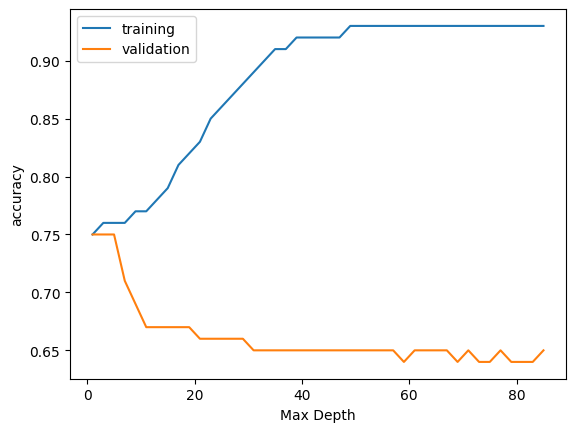

In [43]:
plt.plot(depth_params, accuracy_train, label='training')
plt.plot(depth_params, accuracy_val, label='validation')
plt.xlabel('Max Depth')
plt.ylabel('accuracy')
plt.legend();